# Project 3 OpenClassRooms - Notebook 2
Letizia Pichon

## Import libraries and data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import IPython

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from imblearn.over_sampling import SMOTE
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from nltk.corpus import stopwords
from scipy.stats import shapiro, f_oneway, levene
from sklearn import preprocessing, set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from tqdm import tqdm
from xgboost import XGBClassifier, plot_importance
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


set_config(display="diagram")  # to display a pipeline like a diagram/tree
tqdm.pandas()

## Load data

In [2]:
data = pd.read_pickle('data_clean.pkl')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data_clean.pkl'

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318898 entries, 1 to 1928695
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   code                318898 non-null  object 
 1   product_name        318898 non-null  object 
 2   brands              189852 non-null  object 
 3   categories_en       163977 non-null  object 
 4   labels_en           117002 non-null  object 
 5   countries_en        318898 non-null  object 
 6   nutriscore_score    159530 non-null  float64
 7   nutriscore_grade    159530 non-null  object 
 8   pnns_groups_1       149277 non-null  object 
 9   pnns_groups_2       149277 non-null  object 
 10  ecoscore_score_fr   114811 non-null  float64
 11  ecoscore_grade_fr   114811 non-null  object 
 12  main_category_en    163977 non-null  object 
 13  image_url           297518 non-null  object 
 14  energy-kcal_100g    318898 non-null  float64
 15  fat_100g            318898 non-nu

In [4]:
data.describe(include="all")

,code,product_name,brands,categories_en,labels_en,countries_en,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,...,ecoscore_grade_fr,main_category_en,image_url,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g
count,318898.0,318898,189852,163977,117002,318898,159530.000000,159530,149277,149277,...,114811,163977,297518,318898.000000,3.188980e+05,318898.000000,3.188980e+05,318898.000000,318898.000000,3.188980e+05
unique,318882.0,236185,34180,25696,21400,1126,NaN,5,10,39,...,5,10536,297513,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,360616.0,Mayonnaise,Auchan,"Snacks,Sweet snacks,Biscuits and cakes,Biscuits",Organic,France,NaN,d,Sugary snacks,Biscuits and cakes,...,b,Biscuits,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2.0,271,4861,2188,8578,288399,NaN,47131,30035,21652,...,35983,2286,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,8.680568,NaN,NaN,NaN,...,NaN,NaN,NaN,279.783682,1.391858e+01,4.725777,2.869702e+01,9.762748,8.431476,8.924814e-01
std,NaN,NaN,NaN,NaN,NaN,NaN,8.637140,NaN,NaN,NaN,...,NaN,NaN,NaN,164.291145,1.310777e+01,5.108727,2.462040e+01,12.157327,6.259772,7.506142e-01
min,NaN,NaN,NaN,NaN,NaN,NaN,-15.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,1.000000e-10,0.000000,1.000000e-10,0.000000,0.000000,8.000000e-10
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,137.000000,3.300000e+00,0.700000,5.800000e+00,1.000000,3.700000,2.100000e-01
50%,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,267.000000,1.010000e+01,2.700000,2.080000e+01,3.400000,7.000000,7.900000e-01
75%,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,408.000000,2.110000e+01,7.300000,5.100000e+01,15.900000,12.000000,1.300000e+00


# 1. Analysis

## 1.1 Univariate analysis

### 1.1.1. Numeric columns

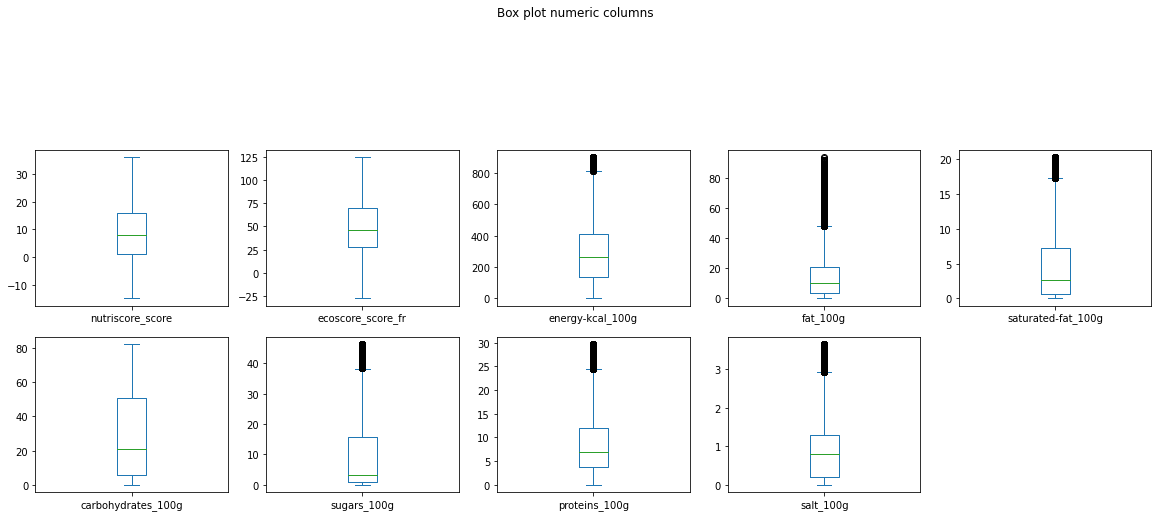

In [5]:
data.plot(kind='box', subplots=True, figsize=(20,20), layout=(6,5), title= 'Box plot numeric columns');

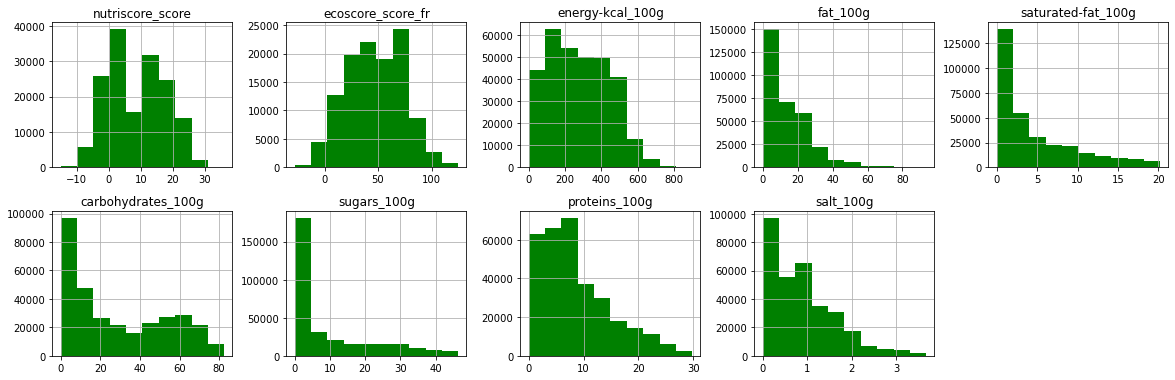

In [6]:
data.hist(figsize=(20,20), layout=(6,5), color = 'green');

These graphs show us that we have removed all the outliers since all the values of all the nutrients are between 0 and 100

### 1.1.2 Categorical columns

#### Scores

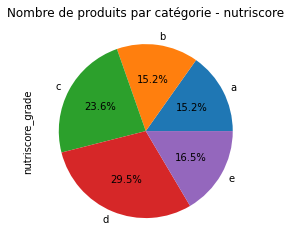

Number of products that have a null nutriscore : 159368




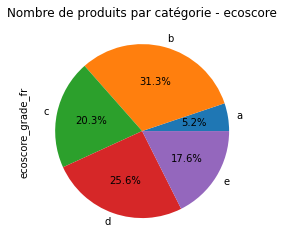

Number of products that have a null ecoscore : 204087




In [7]:
for name, colname in [("nutriscore", "nutriscore_grade"), ("ecoscore", "ecoscore_grade_fr")]:
    (data[colname]
     .value_counts(dropna=True, normalize=True)
     .sort_index()
     .plot(kind="pie", title=f'Nombre de produits par catégorie - {name}', autopct = '%1.1f%%')
    )
    plt.show()
    
    print(f"Number of products that have a null {name} : {data[colname].isnull().sum()}\n\n")

We notice that we have much more data with a high nutriscore (class d and e) than with a low nutriscore (class a and b), which shows us that most of the products are not good for the health

#### Brands

In [8]:
print('Numbrer of brands : ', data['brands'].nunique())

Numbrer of brands :  34180


Number of brands that have a single product  :  22079


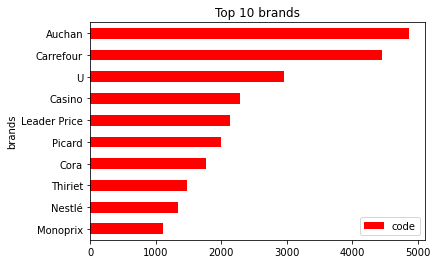

In [9]:
brands = data.groupby('brands')['code'].count().reset_index()
brands.sort_values('code').tail(10).plot.barh(x= 'brands', y= 'code', title = 'Top 10 brands', color='red')

print('Number of brands that have a single product  : ', brands[brands['code']==1].shape[0])

In [10]:
# To delete, based on the above cell
brands = data.groupby('brands')['code'].count().reset_index()
print('Number of brands that have a single product  : ', brands[brands['code']==1].shape[0])

Number of brands that have a single product  :  22079


We notice that the brands of the supermarkets are those which propose the most products

### Products Categories

<AxesSubplot:title={'center':'Top 10,Categories'}, ylabel='main_category_en'>

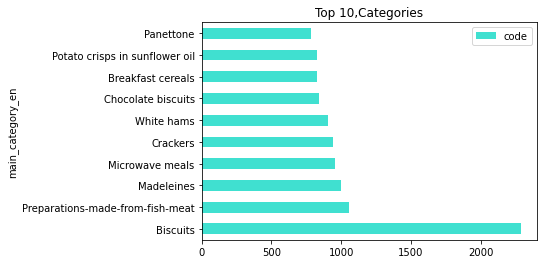

In [11]:
(data.groupby('main_category_en')['code']
 .count()
 .reset_index()
 .sort_values('code', ascending=False)
 .head(10)
 .plot.barh(x= 'main_category_en', y= 'code', title = 'Top 10,Categories', color='turquoise'))

We notice that the most present products are sweet products, snacks and ready-made meals. In general these types of products are not healthy

#### Label

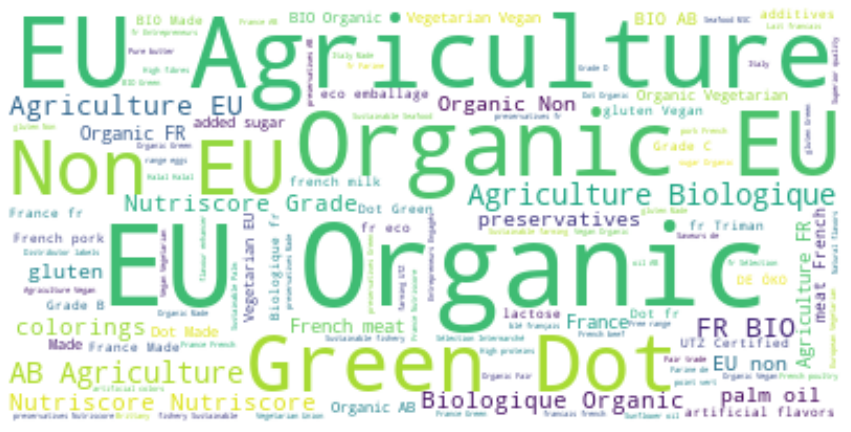

In [12]:
text = " ".join(labels_en for labels_en in data[data.labels_en.notnull()]['labels_en'])

wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,30) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Countries

<AxesSubplot:title={'center':'Top 10 Countries'}, ylabel='countries_en'>

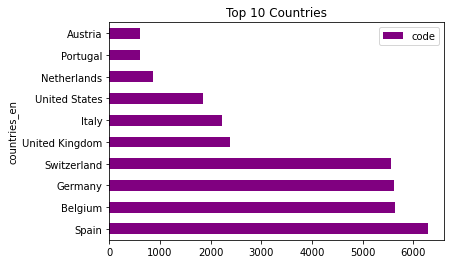

In [13]:
# We split all entries in the 'countries_en' column and create a new row for each in one new dataframe
data['countries_en'] = data['countries_en'].str.split(',')

countries = data[data['countries_en'].notnull()].explode('countries_en')

top_countries = (countries[countries.countries_en!='France']
                 .groupby('countries_en')['code']
                 .count()
                 .reset_index()
                 .sort_values('code', ascending=False)
                 .head(10)
                )
top_countries.plot.barh(x= 'countries_en', y= 'code', title = 'Top 10 Countries', color='purple')

## 1.2 Multivariate analysis

### 1.2.1 Nutriscore vs Nutriments

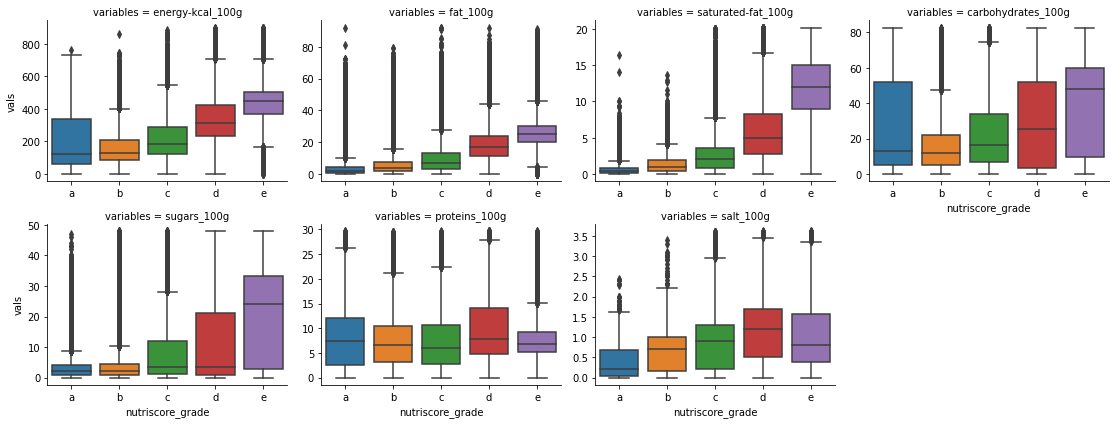

In [20]:
data_melt = data[["nutriscore_grade",
                  'energy-kcal_100g',
                  'fat_100g',
                  'saturated-fat_100g',
                  'carbohydrates_100g',
                  'sugars_100g',
                  'proteins_100g',
                  'salt_100g']
                ].melt("nutriscore_grade", var_name='variables', value_name='vals')
data_melt = data_melt[data_melt['nutriscore_grade'].notnull()]

order = sorted(data[data['nutriscore_grade'].notnull()].nutriscore_grade.unique())

g = sns.catplot(x="nutriscore_grade", y="vals", sharex=False, sharey=False,
                col="variables", data=data_melt, col_wrap=4, order=order, kind='box',
                height=3, aspect=1.3)

The nutrients for which there is a greater difference between the nutriscore categories are fat, sugar and salt

### 1.2.2 Nutriscore in the top 10 brands

<AxesSubplot:title={'center':'Number of products with the nutriscore per brands'}, ylabel='brands'>

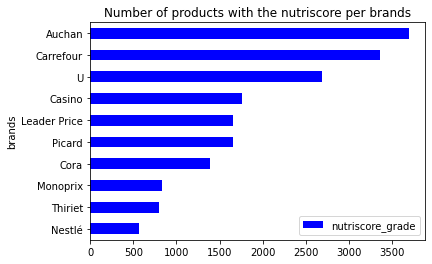

In [22]:
top_brands = data.groupby('brands')['code'].count().reset_index().sort_values('code').tail(10)
brands_top = data[data['brands'].isin(top_brands['brands'].unique().tolist())]

brands_top_nutri = (brands_top
                    .groupby('brands')['nutriscore_grade']
                    .count()
                    .reset_index()
                    .sort_values('nutriscore_grade')
                   )
brands_top_nutri.plot.barh(x='brands', y='nutriscore_grade',
                           title='Number of products with the nutriscore per brands', color='blue')

<AxesSubplot:title={'center':'Ratio of products with the nutriscore and all the products per country'}, ylabel='brands'>

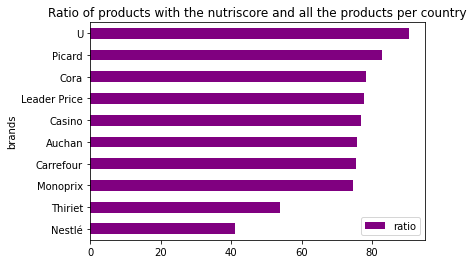

In [23]:
brands_top_nutri = brands_top_nutri.merge(top_brands, on= 'brands')

brands_top_nutri['ratio'] = brands_top_nutri['nutriscore_grade'] / brands_top_nutri['code'] * 100
brands_top_nutri.sort_values('ratio', inplace = True) 
brands_top_nutri.plot.barh(x= 'brands', y= 'ratio',
                           title = 'Ratio of products with the nutriscore and all the products per country',
                           color='purple')

We observe that supermarket brands are the ones that most often have a nutriscore

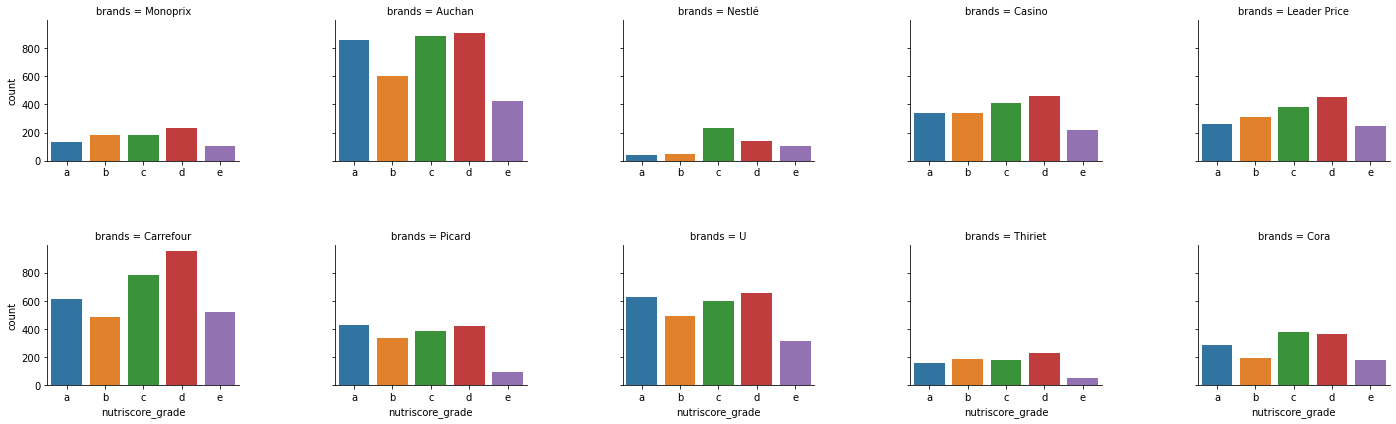

In [24]:
g = sns.catplot(x="nutriscore_grade", col="brands", col_wrap=5, sharex=False,
                data=brands_top,order = order, 
                kind="count", height=3, aspect=1.3)
plt.subplots_adjust(hspace = 0.6, wspace=0.5)

# 2. ANOVA
Hypothesis 0 : products with undefined nutriscores have the same mean on the amount of sugar, salt, proteins, kcal, fat; satured fat and carbohydrates for 100g as the products with a nutriscore class d or e

## 2.1 Prepare data for ANOVA

In [25]:
# fill null nutriscore values
data.nutriscore_grade.fillna('undefined', inplace=True)

# find nutriments columns
onehundred = data.columns[data.columns.str.contains('100')].to_list()

# normalize data
d = preprocessing.normalize(data[onehundred])
scaled_df = pd.DataFrame(d, columns=data[onehundred].columns).reset_index(drop=True)

# log trasformation
scaled_df = scaled_df.applymap(lambda x: np.log(x+1))

# concat normalize with the nutriscore target
data = data.reset_index(drop = True)
df_anova = pd.concat([scaled_df, data['nutriscore_grade']], axis = 1)

# create the two groups we have to compare
df_undefined = df_anova[df_anova['nutriscore_grade']== 'undefined'].drop(columns = ['nutriscore_grade'])
df_d_e = df_anova[df_anova['nutriscore_grade'].isin(['d', 'e'])].drop(columns = ['nutriscore_grade'])

## 2.2 Verify ANOVA assumptions

ANOVA test has 2 assuptions:
 - Observations in each sample are normally distributed = Shapiro test 
 - Observations in each sample have the same variance = Levene test

### 2.2.1 Test the assumptions : Observations in each sample are normally distributed

In [26]:
for el in scaled_df.columns:
    print(el)
    stat, p = shapiro(scaled_df[el])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')
    print('___________________________________________________')

energy-kcal_100g
stat=0.102, p=0.000
Probably not Gaussian
___________________________________________________
fat_100g
stat=0.647, p=0.000
Probably not Gaussian
___________________________________________________
saturated-fat_100g
stat=0.667, p=0.000
Probably not Gaussian
___________________________________________________
carbohydrates_100g
stat=0.868, p=0.000
Probably not Gaussian
___________________________________________________
sugars_100g
stat=0.771, p=0.000
Probably not Gaussian
___________________________________________________
proteins_100g


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


stat=0.661, p=0.000
Probably not Gaussian
___________________________________________________
salt_100g
stat=0.311, p=0.000
Probably not Gaussian
___________________________________________________


🚨 None of the variables are normally distributed. ANOVA results will not be valid 

### 2.2.2 Test the assumptions : Observations in each sample have the same variance

In [27]:
for el in scaled_df.columns:
    print(el)
    stat, p = levene(df_undefined[el], df_d_e[el])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the populations have equal variances')
    else:
        print('Probably the populations do not have equal variances')
    print('___________________________________________________')

energy-kcal_100g
stat=423.230, p=0.000
Probably the populations do not have equal variances
___________________________________________________
fat_100g
stat=714.818, p=0.000
Probably the populations do not have equal variances
___________________________________________________
saturated-fat_100g
stat=35.369, p=0.000
Probably the populations do not have equal variances
___________________________________________________
carbohydrates_100g
stat=71.385, p=0.000
Probably the populations do not have equal variances
___________________________________________________
sugars_100g
stat=11.717, p=0.001
Probably the populations do not have equal variances
___________________________________________________
proteins_100g
stat=831.895, p=0.000
Probably the populations do not have equal variances
___________________________________________________
salt_100g
stat=781.410, p=0.000
Probably the populations do not have equal variances
___________________________________________________


🚨 nothing have equal variance

## 2.3 ANOVA test

In [28]:
stat, ps = f_oneway(df_undefined, df_d_e)
anova = pd.DataFrame({'feature': df_undefined.columns, 
                     'p' : ps,
                     'HO : Probably the same distribution' : ps > 0.05})
anova

,feature,p,HO : Probably the same distribution
0,energy-kcal_100g,3.217189e-103,False
1,fat_100g,0.000000e+00,False
2,saturated-fat_100g,0.000000e+00,False
3,carbohydrates_100g,0.000000e+00,False
4,sugars_100g,8.559414e-01,True
5,proteins_100g,0.000000e+00,False
6,salt_100g,2.263572e-137,False


# 3. CLASSIFICATION

In [14]:
df = pd.read_pickle("data_clean_all_nutriments.pkl")
df.nutriscore_grade.fillna('undefined', inplace=True)
df.fillna(0, inplace=True)
print("the data shape is : {}".format(df.shape))
df.head(3)

the data shape is : (287211, 109)


,code,nutriscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,...,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,undefined,375.0,7.0,3.08,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000000000178,undefined,60.0,3.0,1.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0000000000949,b,32.0,0.3,0.10,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.1 Normalize data and changing categorical string to numerical codes

Normalizing helps the gradient backpropagation during the training phases. It helps to have a set of values which are more easily comparable because they are scaled

In [19]:
scaler = preprocessing.MinMaxScaler()

# scale only data which are numerical 
numerical = df.columns[df.columns.str.contains("100")].to_list()
scaled_df = pd.DataFrame(scaler.fit_transform(df[numerical]), columns=numerical) # MD no printing

# add back some columns on scaled_df
scaled_df["nutriscore_grade"] = df.nutriscore_grade
scaled_df["code"] = df.code

# filter undefined
scaled_df_undefined = scaled_df[~(scaled_df.nutriscore_grade!='undefined')]
scaled_df = scaled_df[scaled_df.nutriscore_grade!='undefined'].drop(["code"], axis=1)

scaled_df["nutriscore_grade"] = scaled_df.nutriscore_grade.astype("str")
scaled_df.head(3)

,energy-kcal_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,nutriscore_grade
2,0.035556,0.003580,0.005568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b
6,0.423333,0.262530,0.863029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,d
11,0.158889,0.151551,0.055679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b


## 3.2 Creating the training and test set out of the scaled data frame
### 3.2.1 Splitting the data into train and test set 

The training data have : 130065 rows
The testing data have : 14452 rows


<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

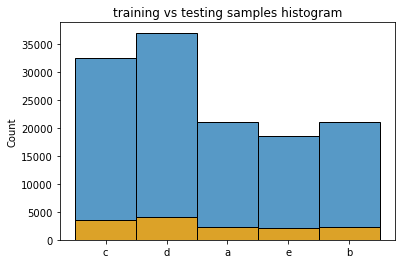

In [20]:
X = scaled_df.drop(columns = ['nutriscore_grade'])
y = scaled_df['nutriscore_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print("The training data have : {} rows\nThe testing data have : {} rows".format(len(y_train), len(y_test)))

# histogram of the train vs test data
plt.title("training vs testing samples histogram")
sns.histplot(y_train.values, )
sns.histplot(y_test.values, color="orange", alpha=.8)

### 3.2.2 Addind statistical oversampling 
The class are imbalanced so adding oversampling forces the algorithms to see more of the under represented classes. 
- It prevents overfitting on the main class 
- It helps to get a better overall accuracy 

🚨 Important to note that we only oversample the training data. The testing data needs to stay the same in order to respect the real life distribution of our problem.

<AxesSubplot:title={'center':'training vs oversampled vs testing samples histogram'}, ylabel='Count'>

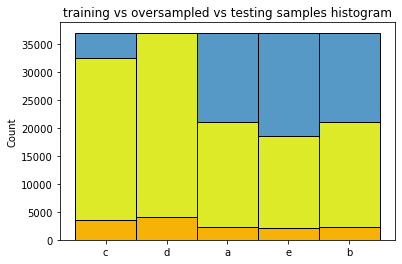

In [21]:
oversample = SMOTE()
X_trainO, y_trainO = oversample.fit_resample(X_train, y_train)

# histogram of the train vs train_oversample vs test data
plt.title("training vs oversampled vs testing samples histogram")
sns.histplot(y_trainO.values)
sns.histplot(y_train.values, color="yellow", alpha=.8, )
sns.histplot(y_test.values, color="orange", alpha=.8)

## 3.3. Training

Let's first train with the regular data and then the oversampled data to see the differences

### 3.3.1 Training on the regular data

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] training on regular data
[+] score : 0.9243703293661777
              precision    recall  f1-score   support

           a       0.92      0.91      0.91      2341
           b       0.88      0.88      0.88      2342
           c       0.91      0.92      0.92      3602
           d       0.95      0.96      0.95      4108
           e       0.96      0.94      0.95      2059

    accuracy                           0.92     14452
   macro avg       0.92      0.92      0.92     14452
weighted avg       0.92      0.92      0.92     14452

Wall time: 38 s


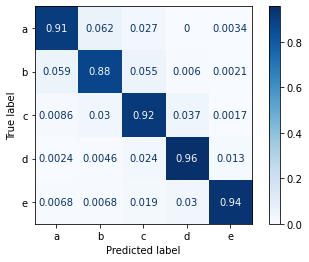

In [33]:
%%time 

# training
model = XGBClassifier(objective ='mlogloss')
model.fit(X_train.values, y_train.values)
score = model.score(X_test.values, y_test.values)
print("[+] training on regular data")
print("[+] score :", score)

y_pred = model.predict(X_test)

# classification report
print(classification_report(y_test.values, y_pred, labels=['a','b','c','d','e']))

# confusion matrix
plot_confusion_matrix(model, X_test.values, y_test.values, cmap=plt.cm.Blues, normalize='true')

### 3.2 Training on the oversampled data

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] training on oversampled data
[+] score : 0.920633822308331
              precision    recall  f1-score   support

           a       0.91      0.91      0.91      2341
           b       0.85      0.88      0.87      2342
           c       0.92      0.91      0.91      3602
           d       0.96      0.95      0.95      4108
           e       0.95      0.95      0.95      2059

    accuracy                           0.92     14452
   macro avg       0.92      0.92      0.92     14452
weighted avg       0.92      0.92      0.92     14452



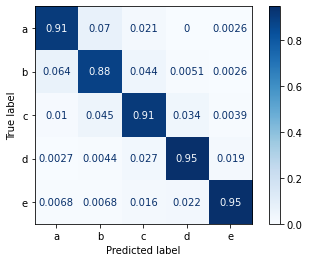

In [34]:
model = XGBClassifier()
model.fit(X_trainO.values, y_trainO.values)
score = model.score(X_test.values, y_test.values)
print("[+] training on oversampled data")
print("[+] score :", score)
y_pred = model.predict(X_test)

# classification report
print(classification_report(y_test.values, y_pred, labels=['a','b','c','d','e']))

# confusion matrix
plot_confusion_matrix(model, X_test.values, y_test.values, cmap=plt.cm.Blues, normalize='true')


In [ ]:
fig = plt.figure(figsize=(10,30))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_trainO.columns[sorted_idx], model.feature_importances_[sorted_idx])

### 3.3.3 Doing a StratifiedKFold 
in order to see if our algorithms is robust to different split training and validate that our performance is not just due to a lucky repartition between training and testing set let's run a 5cv

🚨 Why stratified :  because it helps in the case of unbalanced dataset to pick by strats which helps to get a better idea on how the algorithms performs on all classes

In [22]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9207030168834763, Precision: 0.9159354823586859, Recall: 0.9186206310604497


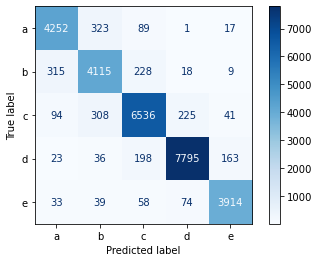

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9183849986161084, Precision: 0.9155597073918862, Recall: 0.9170243277349723


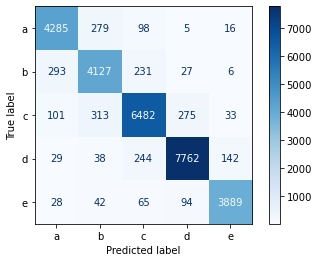

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9211500536276511, Precision: 0.9186002219423791, Recall: 0.919382302647336


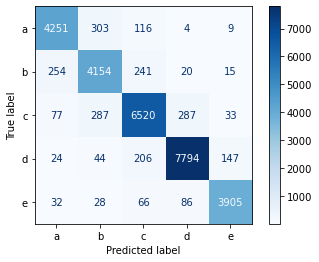

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:39:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9185205687990866, Precision: 0.9155942210651442, Recall: 0.9167271902775498


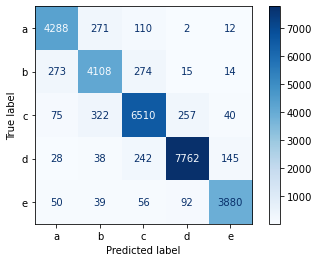

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9183129778915683, Precision: 0.9145270582614522, Recall: 0.9163918107788586


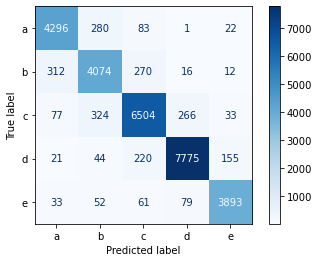

Mean Accuracy: 0.9194143231635781, Mean Precision: 0.9160433382039095, Mean Recall: 0.9176292524998333


In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

# define the stratified kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# add list to keep tracks
accs, precs, recs = [], [], []
for train_index, test_index in skf.split(X, y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    oversample = SMOTE()
    X_trainO, y_trainO = oversample.fit_resample(X_train, y_train)

    model = XGBClassifier()
    model.fit(X_trainO.values, y_trainO.values)
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average = 'macro')
    rec = recall_score(y_test, y_pred, average = 'macro')
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}')
    
    plot_confusion_matrix(model, X_test.values, y_test.values, cmap=plt.cm.Blues)
    plt.show()

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}')

### 3.3.4 Fine Tuning

In [46]:
X = scaled_df.drop(columns = ['nutriscore_grade'])
y = scaled_df['nutriscore_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42 , stratify=y)

space={'max_depth': hp.choice("max_depth", range(5, 20, 1)), # default 6
        'gamma': hp.uniform ('gamma',1 , 9),                # default 0
        'reg_alpha' : hp.quniform('reg_alpha', 0, 180, 5),     # default 0
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),        # default 1
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),       # default 1
        'min_child_weight' : hp.quniform('min_child_weight', 0, 1, 0.05),# default 1
        'objective' : 'mlogloss' #multiclass
    }

def hyperparameter_tuning(space):
    model = XGBClassifier(**space)
    #evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=3,
            trials=trials)

print(best)

  0%|                                                                            | 0/3 [00:00<?, ?trial/s, best loss=?]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:46:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                                                                 
0.8921948519236091                                                                                                     
 33%|████████████████                                | 1/3 [01:46<03:33, 106.96s/trial, best loss: -0.8921948519236091]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:47:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                                                                 
0.8871436479380017                                                                                                     
 67%|████████████████████████████████▋                | 2/3 [03:01<01:28, 88.15s/trial, best loss: -0.8921948519236091]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[10:49:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                                                                 
0.8751037918627179                                                                                                     
100%|█████████████████████████████████████████████████| 3/3 [03:59<00:00, 79.78s/trial, best loss: -0.8921948519236091]
{'colsample_bytree': 0.6993952030085863, 'gamma': 5.128939285984636, 'max_depth': 12, 'min_child_weight': 0.15000000000000002, 'reg_alpha': 55.0, 'reg_lambda': 0.5188731338306766}


### 3.4 Save the best model

In the end the model that gives us the best performance is the model with the default values. So we will save and use this model to predict the nutriscore of the products they have not 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
model = XGBClassifier(objective ='mlogloss')
model.fit(X_train.values, y_train.values)
score = model.score(X_test.values, y_test.values)

filename = 'classification_model.joblib'
joblib.dump(model, filename)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['classification_model.joblib']

## 3.4 Predict on the undefined 

<AxesSubplot:ylabel='Count'>

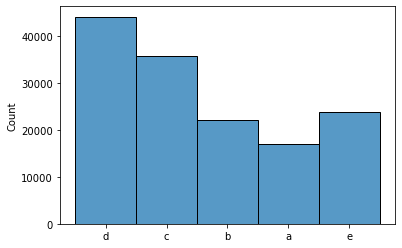

In [35]:
# predict nutriscore for the product with un undefined nutriscore
results = model.predict(scaled_df_undefined.drop(["code", "nutriscore_grade"], axis=1).values)
sns.histplot(results)

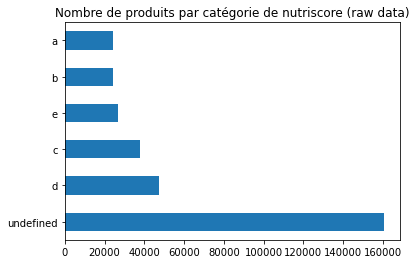

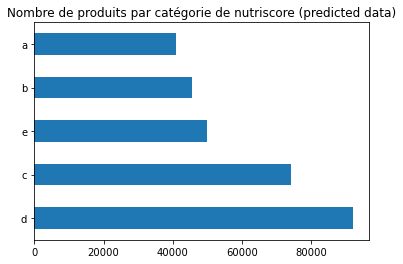

In [69]:
scaled_df_undefined = scaled_df_undefined[["code", "nutriscore_grade"]]
scaled_df_undefined["nutriscore_grade"] = results

data_nutriscore = data[data['nutriscore_grade']!= 'undefined'].reset_index(drop=True)
data_undefined = data[data['nutriscore_grade']== 'undefined'].drop(columns=['nutriscore_grade']).reset_index(drop=True)


data_undefined = data_undefined.merge(scaled_df_undefined, on='code', how='left')
data_undefined = data_undefined[data_undefined.nutriscore_grade.notnull()]

data_results = pd.concat([data_nutriscore, data_undefined])

data.nutriscore_grade.value_counts().plot(kind = 'barh')
plt.title('Nombre de produits par catégorie de nutriscore (raw data)')
plt.show()

data_results.nutriscore_grade.value_counts().plot(kind = 'barh')
plt.title('Nombre de produits par catégorie de nutriscore (predicted data)')
plt.show()

# 4. Recommendation system

In [4]:
# drop products without categories or image
data_rec = data[data['main_category_en'].notnull()].reset_index(drop = True).drop_duplicates('product_name')
data_rec = data_rec[data_rec['image_url'].notnull()]

# concat the product name and all the category columns in one colum
data_rec['category'] = data_rec[['product_name',
                                 'main_category_en',
                                 'categories_en',
                                 'pnns_groups_1',
                                 'pnns_groups_2']].applymap(str).apply(' '.join, axis=1)

del data

In [5]:
# define stopwords list
stopwords_list = stopwords.words('english') + stopwords.words('french')

# vectorize products
vectorizer = TfidfVectorizer(stop_words=stopwords_list,
                             ngram_range=(1,2),
                             max_df=1.0,
                             min_df=1,
                             use_idf=False,
                             norm='l1',
                             sublinear_tf=False)

tfidf_matrix = vectorizer.fit_transform(data_rec['category'])

In [19]:
indices_code = pd.Series(data_rec.index, index=data_rec['code']).drop_duplicates()

class Recommender:
    def __init__(self, product_name=None, product_code=None, topn= 10):
        if product_code:
            self.product_vect = tfidf_matrix[indices_code[product_code]]
        elif product_name:
            self.product_vect = vectorizer.transform([product_name])
        else:
            raise ValueError('Enter Product name or product code')
        self.topn = topn

    def _diplay_recommendations(self, products):
        # for each product reccomended display the name, the brand and the image
        for el in products:
            image_url, nutriscore_grade, brand = data_rec.loc[data_rec['product_name']==el,
                                                              ['image_url', 'nutriscore_grade','brands']].values[0]
            display(f"{el} -- Brand : {brand}")
            display(f"Nutriscore : {nutriscore_grade}")
            display(IPython.display.Image(image_url, width = 70, height=70))
            print('\n')

    def get_recommendations(self):
        #calculate similarity with the other products
        cosine_similarities = cosine_similarity(self.product_vect, tfidf_matrix)
        
        # find the most similar products
        similar_indices = cosine_similarities.argsort().flatten()[-self.topn:]
        products = data_rec[['product_name','nutriscore_grade']].iloc[similar_indices].sort_values('nutriscore_grade')['product_name'].to_list() 
        return self._diplay_recommendations(products)

'Rijstpap - riz au lait -- Brand : nan'

'Nutriscore : b'

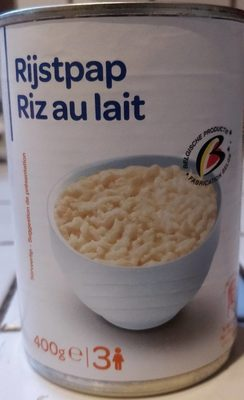

'Riz Au Lait -- Brand : Auchan'

'Nutriscore : b'

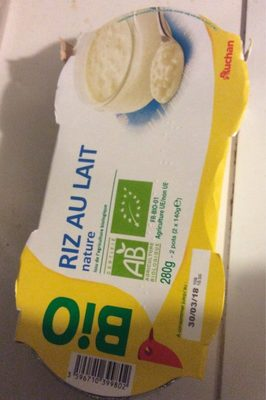

'Le riz au lait -- Brand : nan'

'Nutriscore : b'

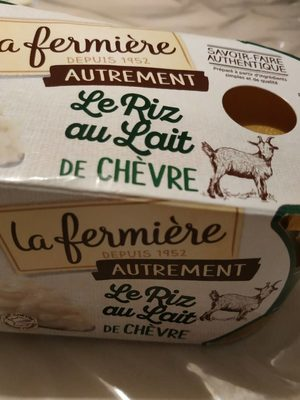

'Dessert Céréales Riz au lait -- Brand : Mont blanc'

'Nutriscore : c'

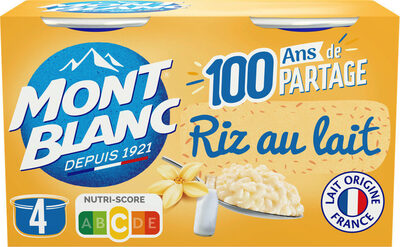

'Riz au lait à la confiture de lait -- Brand : Les Desserts du Val de Sée'

'Nutriscore : c'

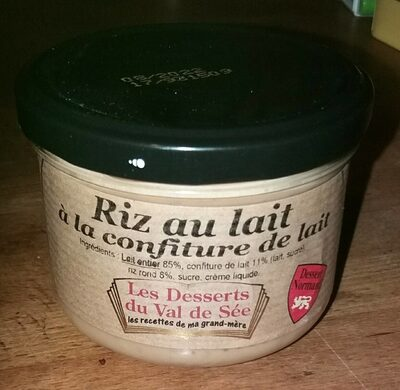

'Riz au lait et confiture de lait -- Brand : Bon App Carrefour, Carrefour'

'Nutriscore : c'

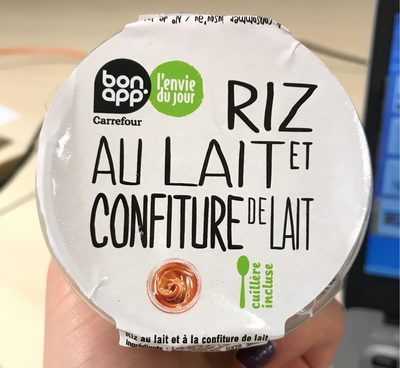

"l'incroyable riz au lait -- Brand : Michel et Augustin"

'Nutriscore : c'

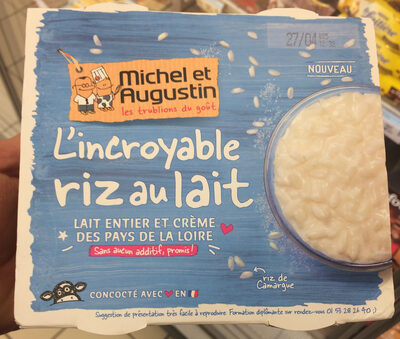

'Riz au lait -- Brand : Bonne Maman'

'Nutriscore : c'

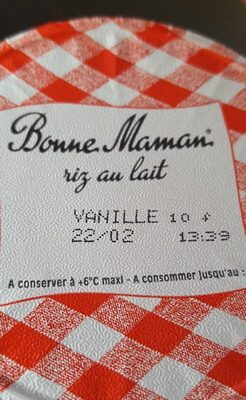

'Mon riz au lait -- Brand : Bonne Maman'

'Nutriscore : c'

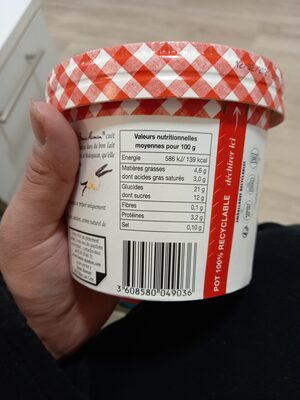

'🍚Riz au lait🥛 -- Brand : La Fermière'

'Nutriscore : c'

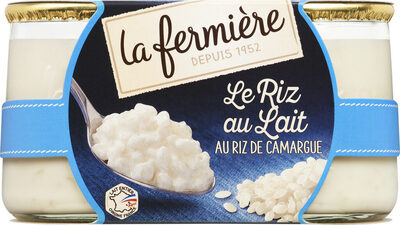

In [23]:
myrecommender = Recommender(product_code="00000006")
myrecommender.get_recommendations()